### A/B Testing Analysis

<h8>A cooking website sells cooking equipment. They want to improve their product page. The product page has a rail with media (images or videos). Up until now, they have had a horizontal rail, a UX designer suggested having a vertical one. As a data analyst in the company, you suggested doing an AB test. You now have the results of the test and need to advise the company on whether they should ship the feature (vertical media rail) or not </h8>

In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from scipy.stats import norm
from scipy.stats import ttest_ind

In [24]:
os.getcwd()

'C:\\Users\\NoteBook'

In [25]:
df = pd.read_csv('assessment_da25.csv')
df.head()

,Variant,Number of page views,GMV (in $),Number of add to cart,Clicks on media,Time on Page (sec),user_id
0,A,5,0.0,0,2,74,0
1,A,4,0.0,4,1,21,1
2,A,4,0.0,2,0,1,2
3,A,5,0.0,0,1,26,3
4,A,5,0.0,3,3,46,4


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Variant                2000 non-null   object 
 1   Number of page views   2000 non-null   int64  
 2   GMV (in $)             2000 non-null   float64
 3   Number of add to cart  2000 non-null   int64  
 4   Clicks on media        2000 non-null   int64  
 5   Time on Page (sec)     2000 non-null   int64  
 6   user_id                2000 non-null   int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 109.5+ KB


In [27]:
df['Variant'].value_counts()

Variant
A    1000
B    1000
Name: count, dtype: int64

### Aggregating metrics

In [28]:
summary_stats = df.groupby('Variant').agg({
    'Number of page views': ['mean', 'std'],
    'GMV (in $)':['mean', 'std'],
    'Number of add to cart': ['mean', 'std'],
    'Clicks on media':['mean', 'std'],
    'Time on Page (sec)': ['mean', 'std'],
}).reset_index()

summary_stats

Variant Number of page views           GMV (in $)             \
                          mean       std       mean        std   
0       A                4.985  2.236465    7.68999  26.794816   
1       B                5.317  2.417096    9.28953  28.879687   

  Number of add to cart           Clicks on media            \
                   mean       std            mean       std   
0                 1.884  1.297778           1.495  1.230239   
1                 2.469  1.660662           1.324  1.180855   

  Time on Page (sec)             
                mean        std  
0             20.543  20.596076  
1             20.047  19.319784

### Visualize distributions

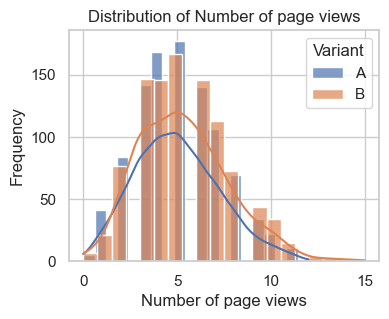

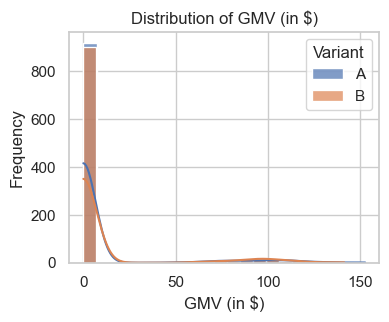

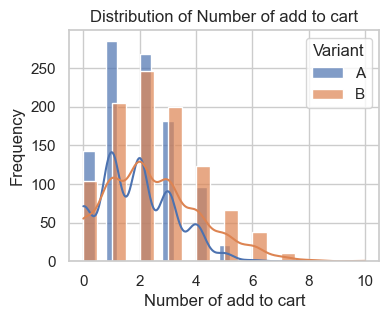

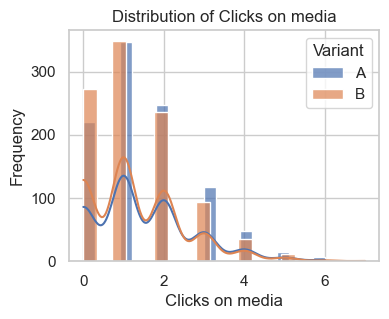

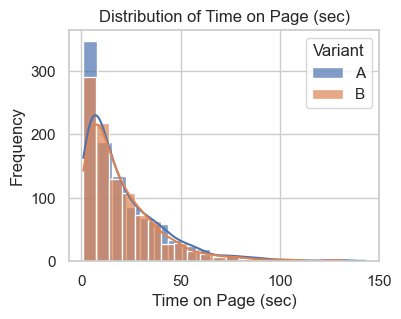

In [29]:
metrics = ['Number of page views', 'GMV (in $)', 'Number of add to cart', 'Clicks on media', 'Time on Page (sec)']

# Set the style of seaborn
sns.set(style="whitegrid")

# Plot histograms for each metric
for metric in metrics:
    plt.figure(figsize=(4, 3))
    for variant in df['Variant'].unique():
        sns.histplot(data=df[df['Variant'] == variant], x=metric, kde=True, bins=20, label=variant, alpha=0.7)
    plt.title(f'Distribution of {metric}')
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    plt.legend(title='Variant')
    plt.show()


### Ploting the mean of metrics

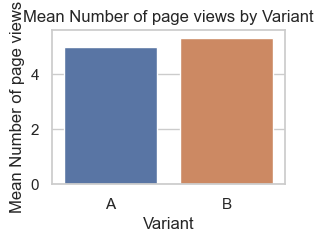

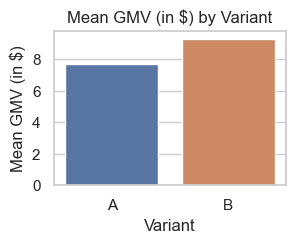

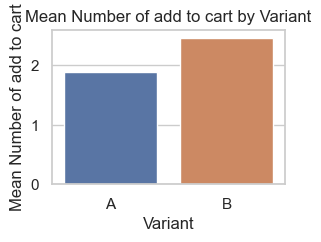

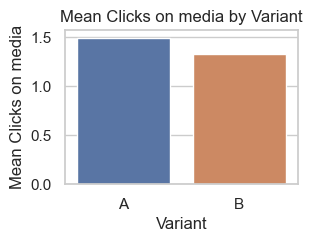

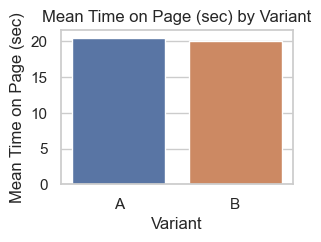

In [30]:
df_no_user_id = df.drop(columns=['user_id'])

# Calculate the mean for each metric and variant
metric_means = df_no_user_id.groupby(["Variant"]).mean()

# Plot the mean for each metric
for metric in metric_means.columns:
    plt.figure(figsize=(3,2))
    sns.barplot(x=metric_means.index, y=metric, data=metric_means, errorbar=None)
    plt.title(f'Mean {metric} by Variant')
    plt.xlabel('Variant')
    plt.ylabel(f'Mean {metric}')
    plt.show()

### Two-sample z-test for proportions

In [31]:
Primary_metric = 'Conversion Rate'

conversions_A = df[df['Variant'] == 'A']['Number of add to cart'].sum()
total_page_views_A = df[df['Variant'] == 'A']['Number of page views'].sum()

conversions_B = df[df['Variant'] == 'B']['Number of add to cart'].sum()
total_page_views_B = df[df['Variant'] == 'B']['Number of page views'].sum()

conversion_rate_A = round(conversions_A / total_page_views_A, 2)
conversion_rate_B = round(conversions_B / total_page_views_B, 2)

# Calculate pooled proportion
p_pool = (conversions_A + conversions_B) / (total_page_views_A + total_page_views_B)

# Calculate standard error
SE = ((p_pool * (1 - p_pool)) * (1 / total_page_views_A + 1 / total_page_views_B)) ** 0.5

# Calculate z-statistic
z_stat = (conversion_rate_A - conversion_rate_B) / SE

# Calculate p-value
p_value = 2 * (1 - norm.cdf(abs(z_stat)))  # Two-tailed test

# Print results
print('z-statistic: {:.3f}'.format(z_stat))
print('p-value: {:.3f}'.format(p_value))

alpha = 0.05
if p_value < alpha:
    print('The difference in Conversion Rate between variant A and variant B is statistically significant.')
else:
    print('There is no statistically significant difference in Conversion Rate between variant A and variant B.')
print ('Conversion Rate for Variant A:', conversion_rate_A)
print ('Conversion Rate for Variant B:', conversion_rate_B)

z-statistic: -8.215
p-value: 0.000
The difference in Conversion Rate between variant A and variant B is statistically significant.
Conversion Rate for Variant A: 0.38
Conversion Rate for Variant B: 0.46


### Two-sample t-test

In [33]:
Secondary_metric = 'User Engagement'

# Define the user engagement metrics
user_engagement_metrics = ['Number of page views', 'Clicks on media', 'Time on Page (sec)']

# Perform t-test for each user engagement metric
for metric in user_engagement_metrics:
    # Extract data for variant A and variant B
    data_A = df[df['Variant'] == 'A'][metric]
    data_B = df[df['Variant'] == 'B'][metric]
    
    # Perform independent t-test
    t_statistic, p_value = ttest_ind(data_A, data_B, equal_var=False)  # Assuming unequal variances
    
    # Print results
    print(f"T-test for {metric}:")
    print(f"    t-statistic: {t_statistic:.3f}")
    print(f"    p-value: {p_value:.3f}")
    if p_value < 0.05:
        print("    There is a statistically significant difference between the means of variant A and variant B for this metric.")
    else:
        print("    There is no statistically significant difference between the means of variant A and variant B for this metric.")


T-test for Number of page views:
    t-statistic: -3.188
    p-value: 0.001
    There is a statistically significant difference between the means of variant A and variant B for this metric.
T-test for Clicks on media:
    t-statistic: 3.171
    p-value: 0.002
    There is a statistically significant difference between the means of variant A and variant B for this metric.
T-test for Time on Page (sec):
    t-statistic: 0.555
    p-value: 0.579
    There is no statistically significant difference between the means of variant A and variant B for this metric.
